# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from tensorflow.keras.models import load_model

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_dir = "/content/drive/MyDrive/data/varsity/"
os.makedirs(target_dir, exist_ok=True)

In [ ]:
# uncomment it to download
# !wget https://raw.githubusercontent.com/yiminghzc/MDST-GNN/main/MDST-GNN/data/exchange_rate.txt.gz -P /content/drive/MyDrive/data/varsity/

In [ ]:
file_path = '/content/drive/MyDrive/data/varsity/exchange_rate.txt.gz'
df = pd.read_csv(file_path, compression='gzip', header=None)

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       7588 non-null   float64
 1   1       7588 non-null   float64
 2   2       7588 non-null   float64
 3   3       7588 non-null   float64
 4   4       7588 non-null   float64
 5   5       7588 non-null   float64
 6   6       7588 non-null   float64
 7   7       7588 non-null   float64
dtypes: float64(8)
memory usage: 474.4 KB


In [ ]:
df.head()

,0,1,2,3,4,5,6,7
0,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
2,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
3,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
4,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,7588.0,0.776974,0.136620,0.483297,0.701422,0.761377,0.873477,1.102536
1,7588.0,1.634105,0.161544,1.211534,1.532887,1.606574,1.707646,2.109000
2,7588.0,0.821811,0.117123,0.618582,0.727901,0.811582,0.920394,1.091524
3,7588.0,0.848146,0.168874,0.548617,0.696864,0.813959,1.014018,1.374079
4,7588.0,0.142833,0.023996,0.109292,0.120814,0.145212,0.159948,0.237954
5,7588.0,0.009343,0.001458,0.006254,0.008331,0.009151,0.009995,0.013202
6,7588.0,0.654418,0.115292,0.393153,0.566000,0.669187,0.734901,0.882379
7,7588.0,0.669673,0.082836,0.523834,0.593287,0.662767,0.731835,0.832556


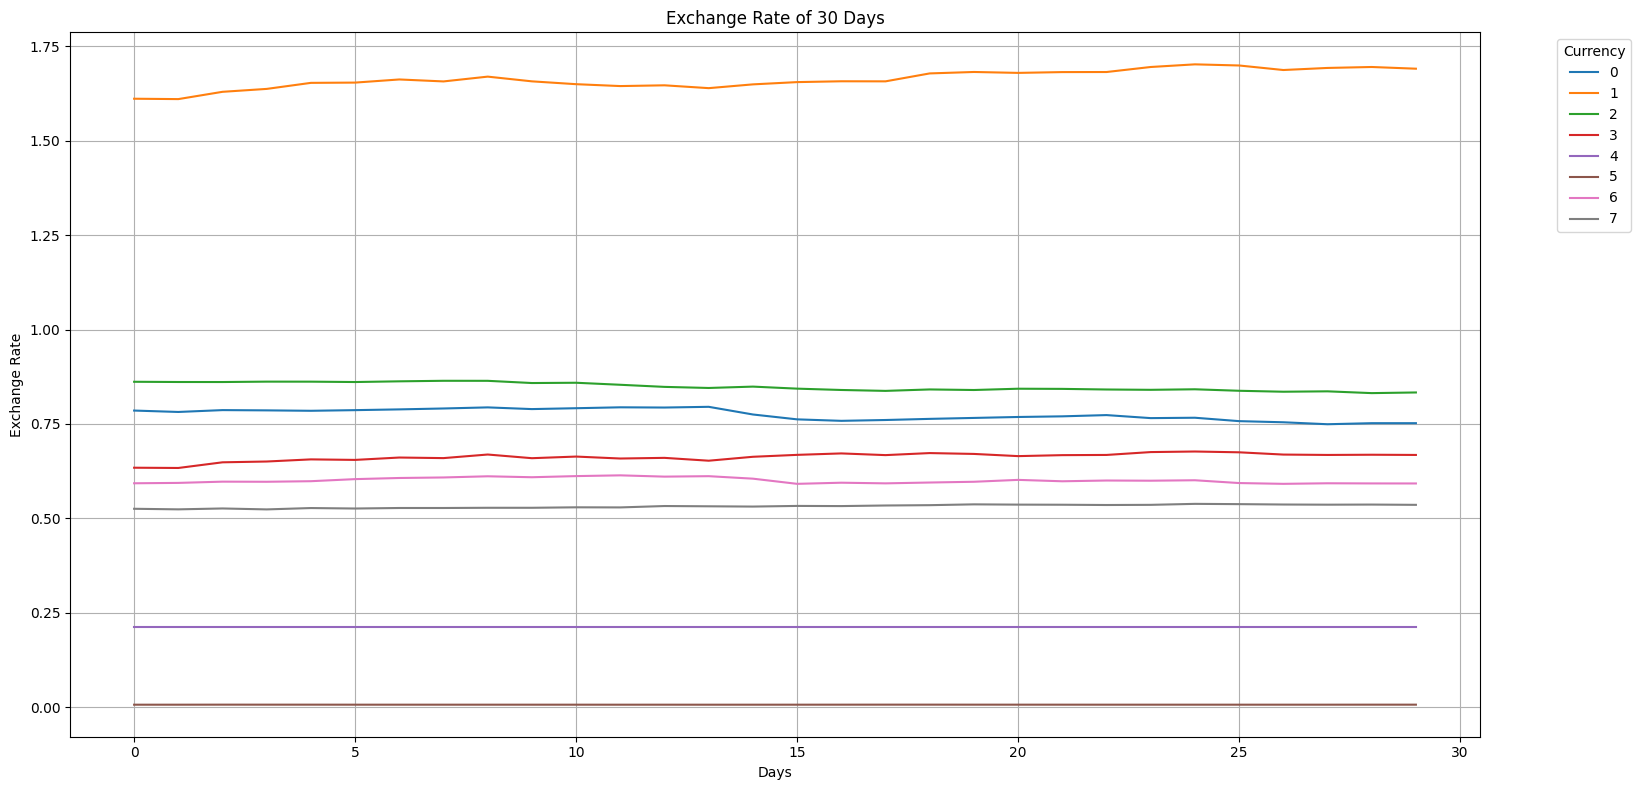

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df.iloc[:30])  # first 30 days, all exchange rates
plt.title('Exchange Rate of 30 Days')
plt.xlabel('Days')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.tight_layout()

# Use dataframe column names as legend labels
plt.legend(df.columns, title="Currency", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


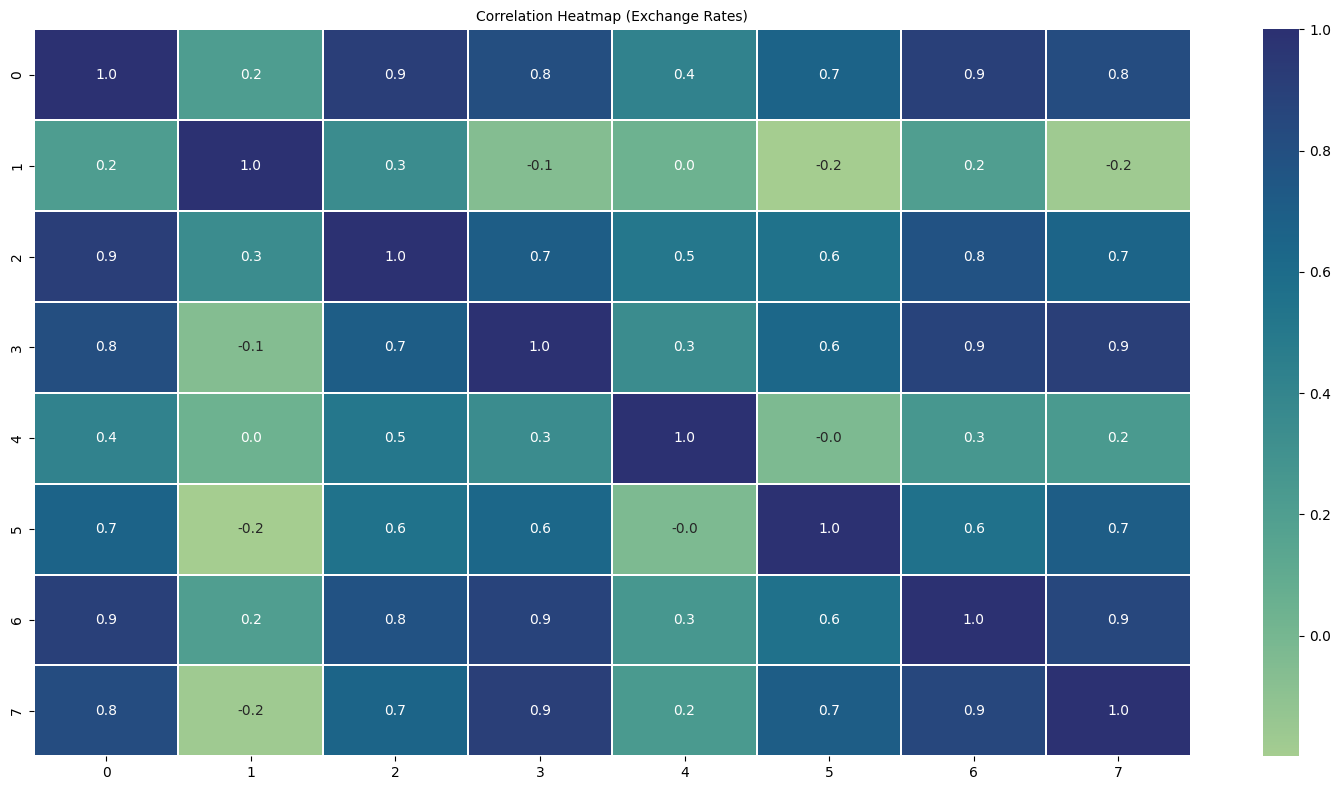

In [ ]:
correlation_subset = df.corr()

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_subset, annot=True, cmap='crest', linewidths=0.2, fmt='.1f')

plt.title('Correlation Heatmap (Exchange Rates)', fontsize=10)
plt.tight_layout()
plt.show()


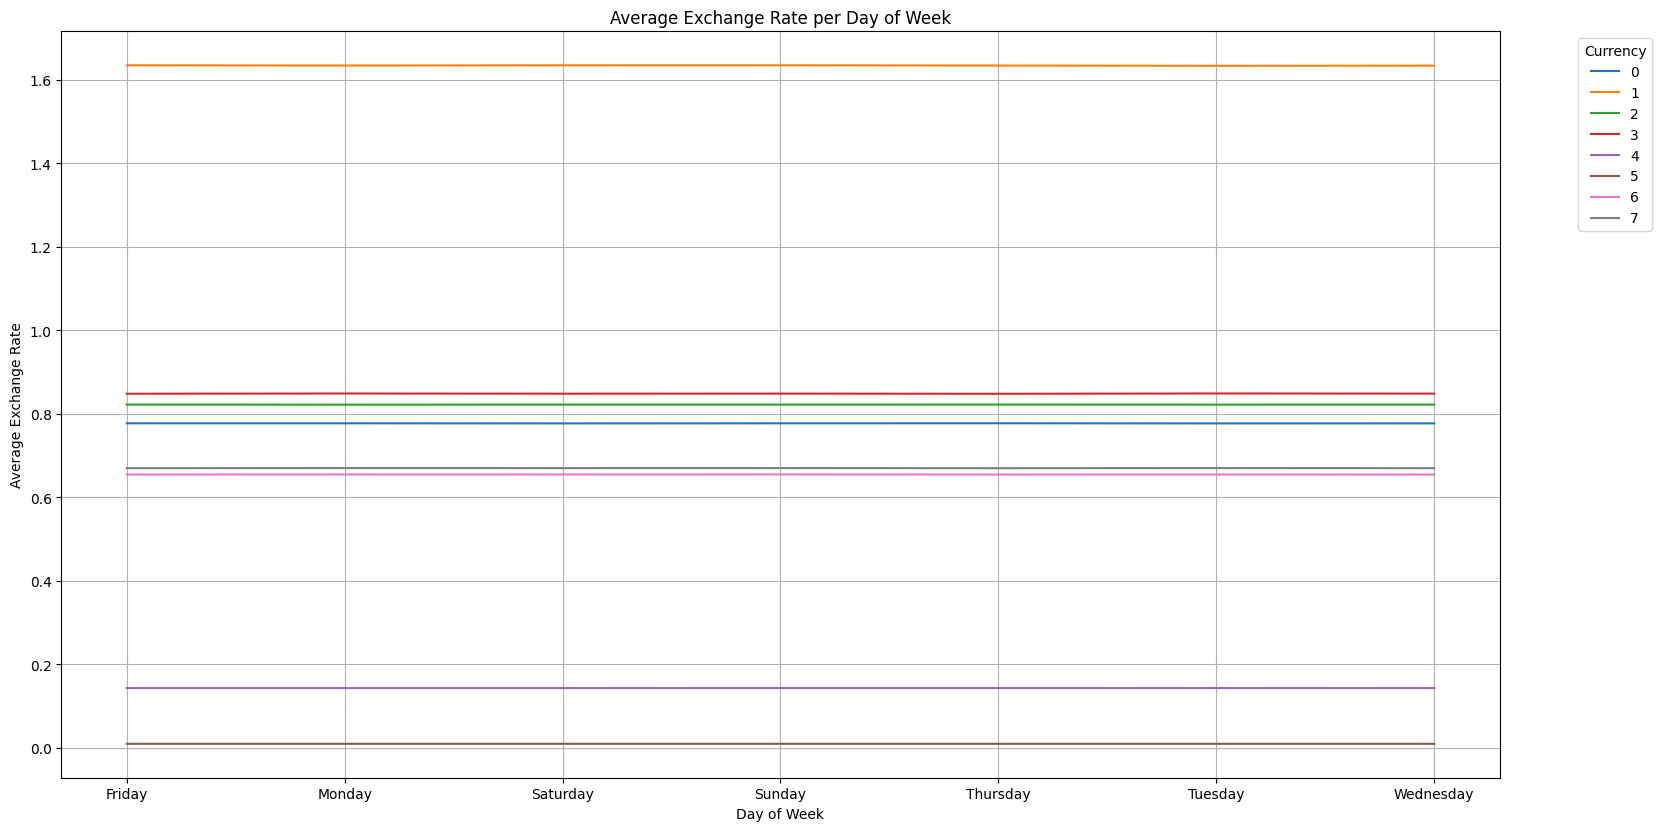

In [ ]:
# Suppose your df index is datetime or just 0..N-1
# Add a day-of-week column if index is datetime
if not isinstance(df.index, pd.DatetimeIndex):
    # create dummy datetime index assuming consecutive days
    df.index = pd.date_range(start='2025-01-01', periods=len(df), freq='D')

df['day_of_week'] = df.index.day_name()  # Monday, Tuesday, etc.

# Plot average exchange rate per day of week for all currencies
plt.figure(figsize=(15, 8))
mean_rates = df.groupby('day_of_week').mean()  # mean exchange rate per currency

plt.plot(mean_rates)
plt.grid(True)
plt.tight_layout()
plt.xlabel('Day of Week')
plt.ylabel('Average Exchange Rate')
plt.title('Average Exchange Rate per Day of Week')
plt.legend(df.columns, title='Currency', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


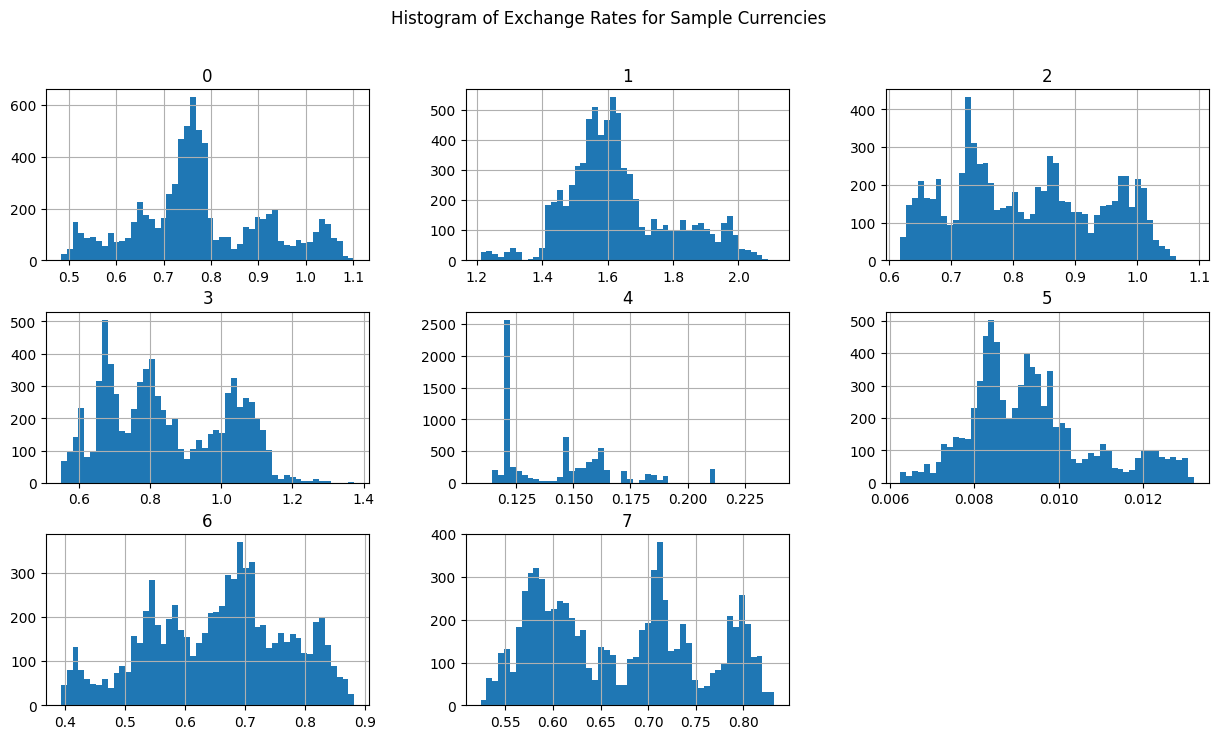

In [ ]:
sample_currencies = df.columns[:]

# Histogram for these currencies
df[sample_currencies].hist(bins=50, figsize=(15,8))
plt.suptitle('Histogram of Exchange Rates for Sample Currencies')
plt.show()

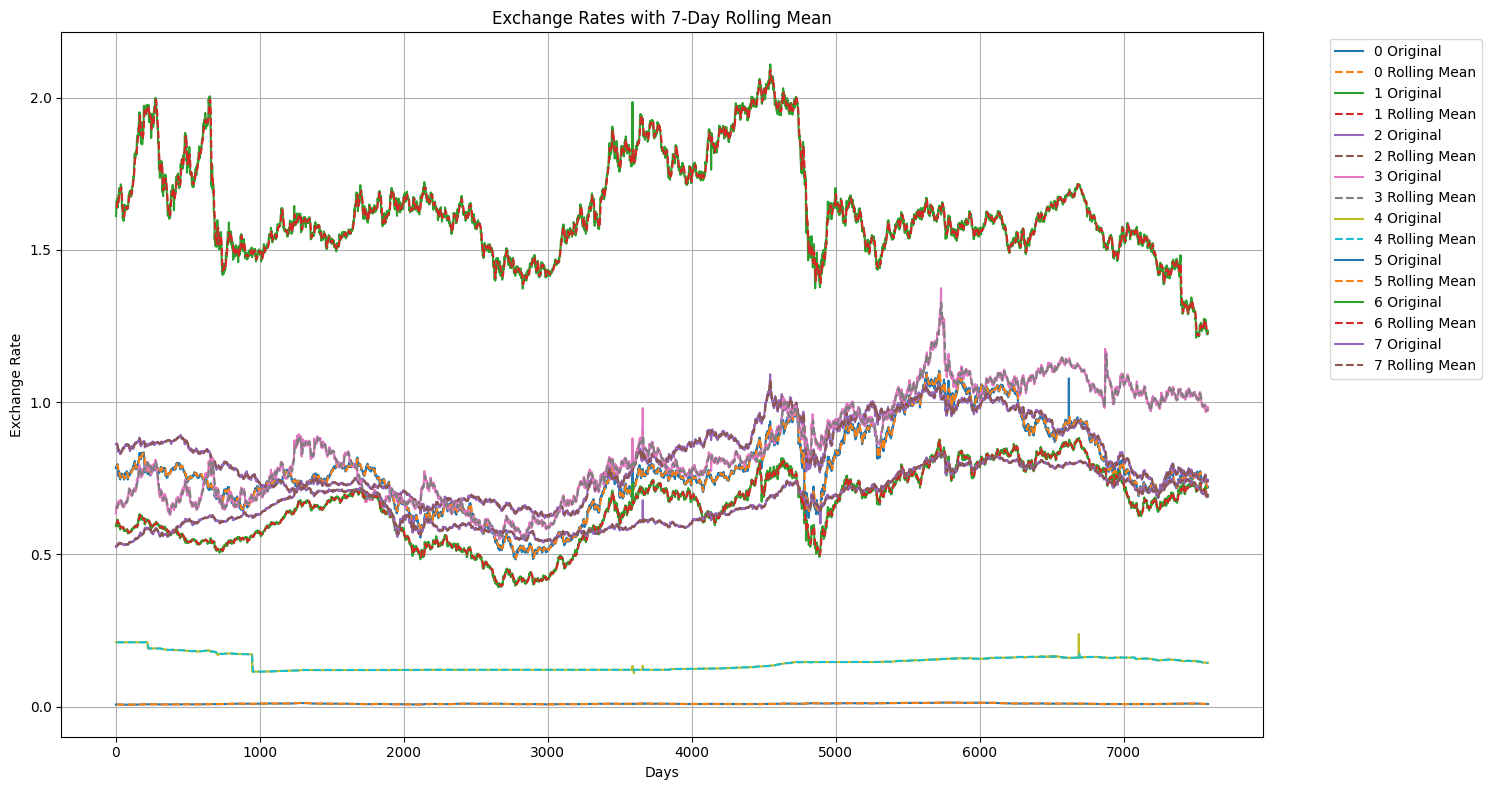

Seasonal decomposition for 0


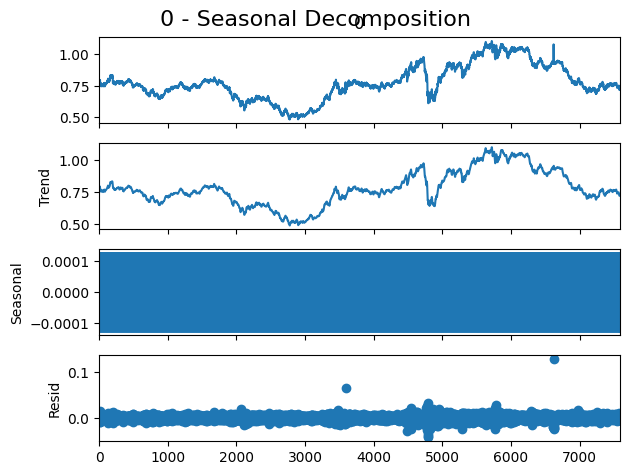

Seasonal decomposition for 1


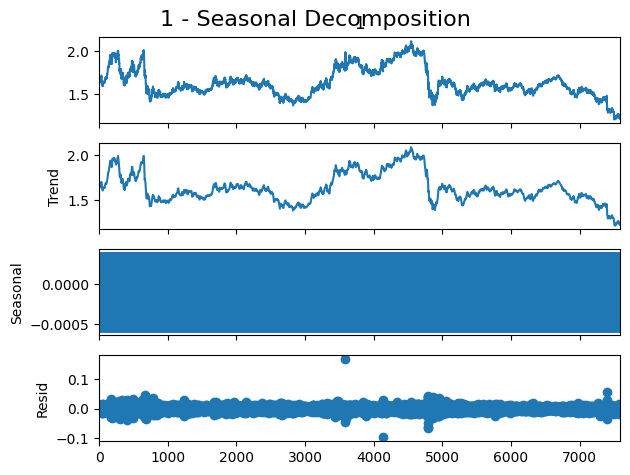

Seasonal decomposition for 2


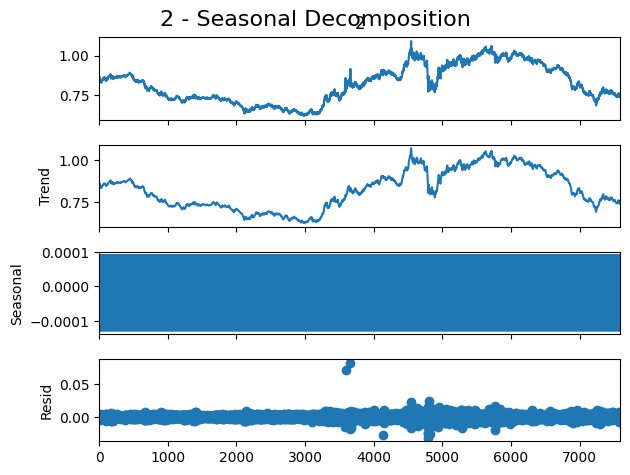

Seasonal decomposition for 3


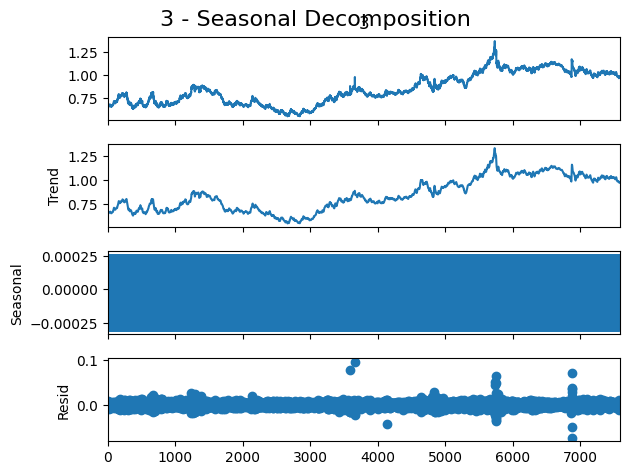

Seasonal decomposition for 4


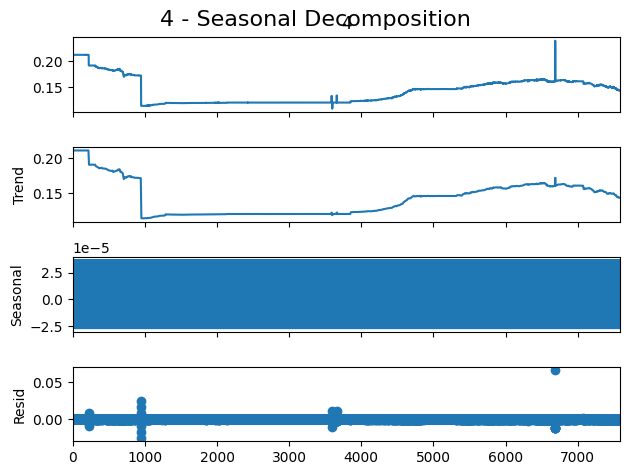

Seasonal decomposition for 5


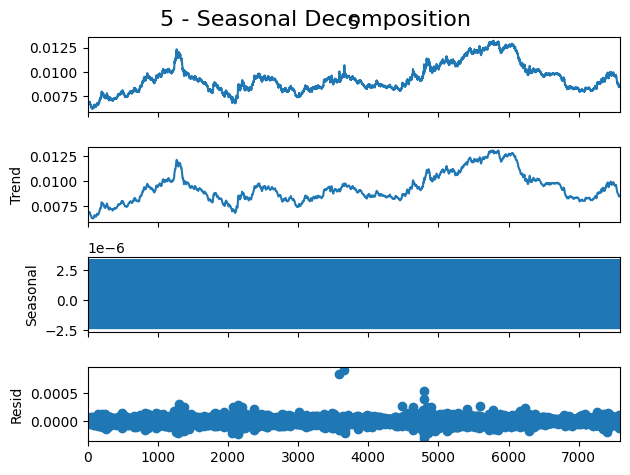

Seasonal decomposition for 6


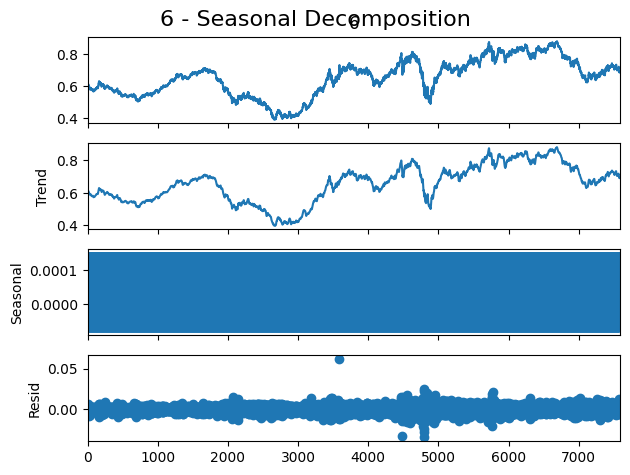

Seasonal decomposition for 7


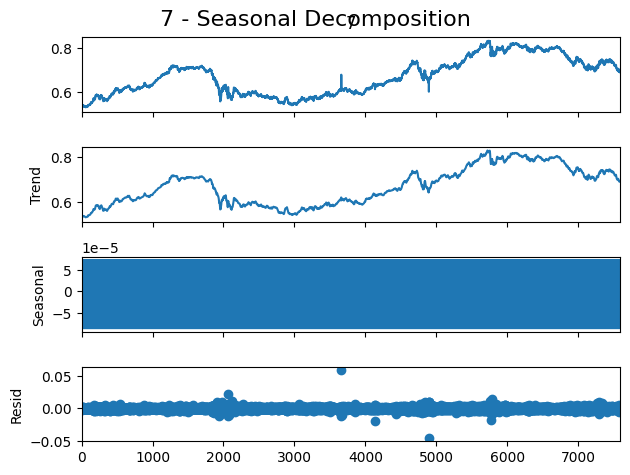

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Example: rolling window of 7 days (weekly)
rolling_window = 7

# Compute rolling mean and std for all currencies
rolling_mean = df.rolling(window=rolling_window).mean()
rolling_std = df.rolling(window=rolling_window).std()

# Plot rolling statistics for each currency
plt.figure(figsize=(15, 8))
for col in df.columns:
    plt.plot(df[col], label=f"{col} Original")
    plt.plot(rolling_mean[col], linestyle='--', label=f"{col} Rolling Mean")
plt.title(f"Exchange Rates with {rolling_window}-Day Rolling Mean")
plt.xlabel("Days")
plt.ylabel("Exchange Rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Seasonal decomposition for all currencies (adjust period as needed, e.g., 7 for weekly, 30 for monthly)
for col in df.columns:
    print(f"Seasonal decomposition for {col}")
    result = seasonal_decompose(df[col], model='additive', period=rolling_window)
    result.plot()
    plt.suptitle(f"{col} - Seasonal Decomposition", fontsize=16)
    plt.show()


# Preprocess

In [ ]:
# Time split FIRST
split_ratio = 0.7
split_idx = int(len(df) * split_ratio)

df_train_raw = df.iloc[:split_idx]
df_test_raw  = df.iloc[split_idx:]

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Fit scaler on TRAIN ONLY
scaler = MinMaxScaler()

df_train = pd.DataFrame(
    scaler.fit_transform(df_train_raw),
    columns=df.columns,
    index=df_train_raw.index
)


# Transform TEST using SAME scaler
df_test = pd.DataFrame(
    scaler.transform(df_test_raw),
    columns=df.columns,
    index=df_test_raw.index
)

In [ ]:
window_size = 168
forecast_horizon = 24   # 24 days = 24
batch_size = 24
n_nodes=df_train.shape[1]
n_nodes

8

In [ ]:
def dataset_generator(df, win_size, horizon):
    length = len(df) - win_size - horizon
    for i in range(length):
        x = df.iloc[i:i+win_size].values.astype(np.float32)
        y = df.iloc[i+win_size:i+win_size+horizon].values.astype(np.float32)
        yield x, y

def create_tf_dataset(df, win_size, horizon, batch_size):
    output_signature = (
        tf.TensorSpec(shape=(win_size, df.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(horizon, df.shape[1]), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(df, win_size, horizon),
        output_signature=output_signature
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset = create_tf_dataset(df_train, window_size, forecast_horizon, batch_size).repeat()
test_dataset = create_tf_dataset(df_test, window_size, forecast_horizon, batch_size).repeat()

In [ ]:
# Calculate steps per epoch
import math

train_data_length = len(df_train_raw) - window_size - forecast_horizon
steps_per_epoch = math.ceil(train_data_length / batch_size)

test_data_length = len(df_test_raw) - window_size - forecast_horizon
validation_steps = math.ceil(test_data_length / batch_size)

# Model: PatchedTalNet

In [ ]:
@tf.keras.utils.register_keras_serializable()
class RevIN(tf.keras.layers.Layer):
    def __init__(self, eps=1e-5, affine=True, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.affine = affine

    def build(self, input_shape):
        n = int(input_shape[-1])
        if self.affine:
            self.gamma = self.add_weight(
                name="gamma", shape=(1, 1, n),
                initializer="ones", trainable=True
            )
            self.beta = self.add_weight(
                name="beta", shape=(1, 1, n),
                initializer="zeros", trainable=True
            )
        super().build(input_shape)

    def call(self, x, mode, stats=None):
        if mode == "norm":
            mu = tf.reduce_mean(x, axis=1, keepdims=True)
            sigma = tf.math.reduce_std(x, axis=1, keepdims=True)
            x_hat = (x - mu) / (sigma + self.eps)
            if self.affine:
                x_hat = x_hat * self.gamma + self.beta
            return x_hat, (mu, sigma)

        elif mode == "denorm":
            mu, sigma = stats
            x_hat = x
            if self.affine:
                x_hat = (x_hat - self.beta) / (self.gamma + self.eps)
            return x_hat * (sigma + self.eps) + mu

    def get_config(self):
        config = super().get_config()
        config.update({
            "eps": self.eps,
            "affine": self.affine
        })
        return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, patch_len=16, stride=8, d_model=128, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.patch_len = patch_len
        self.stride = stride
        self.d_model = d_model
        self.dropout_rate = dropout

        self.dropout = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(d_model)
        self.pos_emb = None

    def build(self, input_shape):
        T = int(input_shape[1])
        n_patches = 1 + (T - self.patch_len) // self.stride

        self.pos_emb = self.add_weight(
            name="pos_emb",
            shape=(1, n_patches, self.d_model),
            initializer="random_normal",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, x, training=None):
        patches = tf.signal.frame(
            x, frame_length=self.patch_len,
            frame_step=self.stride,
            axis=1
        )

        B = tf.shape(patches)[0]
        n_patches = tf.shape(patches)[1]
        N = tf.shape(patches)[3]

        patches = tf.reshape(patches, [B, n_patches, self.patch_len * N])
        tokens = self.proj(patches)
        tokens = tokens + self.pos_emb
        tokens = self.dropout(tokens, training=training)
        return tokens

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_len": self.patch_len,
            "stride": self.stride,
            "d_model": self.d_model,
            "dropout": self.dropout_rate
        })
        return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PatchedTalNet(tf.keras.Model):
    def __init__(self, n_nodes, horizon,
                 patch_len=16, patch_stride=8,
                 d_model=128, n_heads=8, n_stack=2,
                 dropout_rate=0.2,
                 pool_lstm_units=None,
                 **kwargs):
        super().__init__(**kwargs)

        self.n_nodes = n_nodes
        self.horizon = horizon
        self.patch_len = patch_len
        self.patch_stride = patch_stride
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_stack = n_stack
        self.dropout_rate = dropout_rate
        self.pool_lstm_units = pool_lstm_units

        self.revin = RevIN()

        self.patch = PatchEmbedding(
            patch_len=patch_len,
            stride=patch_stride,
            d_model=d_model,
            dropout=dropout_rate,
            name="patch_embedding"
        )

        key_dim = max(8, d_model // n_heads)

        self.blocks = []
        for _ in range(n_stack):
            self.blocks.append({
                #
                "attn": tf.keras.layers.MultiHeadAttention(
                    num_heads=n_heads,
                    key_dim=key_dim,
                    dropout=dropout_rate
                ),
                "drop1": tf.keras.layers.Dropout(dropout_rate),
                "add1": tf.keras.layers.Add(),
                "norm1": tf.keras.layers.LayerNormalization(),
                "ffn": tf.keras.Sequential([
                    tf.keras.layers.Dense(4 * d_model, activation="relu"),
                    tf.keras.layers.Dropout(dropout_rate),
                    tf.keras.layers.Dense(d_model),
                ]),
                "drop2": tf.keras.layers.Dropout(dropout_rate),
                "add2": tf.keras.layers.Add(),
                "norm2": tf.keras.layers.LayerNormalization(),
            })

        units = pool_lstm_units if pool_lstm_units else (d_model // 2)

        self.pool = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                units,
                return_sequences=False,
                dropout=dropout_rate * 0.7
            )
        )

        self.out_drop = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

        # container to store attention maps
        self.last_attention_scores = None

    def call(self, x, training=None):

        x, stats = self.revin(x, mode="norm")
        h = self.patch(x, training=training)

        attn_scores_all = []

        for b in self.blocks:
            # *always request attention scores
            attn, scores = b["attn"](
                h, h,
                return_attention_scores=True,
                training=training
            )
            attn_scores_all.append(scores)

            attn = b["drop1"](attn, training=training)
            h = b["add1"]([h, attn])
            h = b["norm1"](h)

            ffn = b["ffn"](h, training=training)
            ffn = b["drop2"](ffn, training=training)
            h = b["add2"]([h, ffn])
            h = b["norm2"](h)

        # store last forward pass attention
        self.last_attention_scores = attn_scores_all

        z = self.pool(h, training=training)
        z = self.out_drop(z, training=training)

        y = self.fc(z)
        y = tf.reshape(y, [-1, self.horizon, self.n_nodes])
        y = self.revin(y, mode="denorm", stats=stats)

        return y

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "horizon": self.horizon,
            "patch_len": self.patch_len,
            "patch_stride": self.patch_stride,
            "d_model": self.d_model,
            "n_heads": self.n_heads,
            "n_stack": self.n_stack,
            "dropout_rate": self.dropout_rate,
            "pool_lstm_units": self.pool_lstm_units,
        })
        return config

In [ ]:
model = PatchedTalNet(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    patch_len=24,
    patch_stride=8,
    d_model=512,
    n_heads=32,
    n_stack=5,
    dropout_rate=0.2
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-5,
    clipnorm=1.0),
    # loss="mse",
    loss= tf.keras.losses.Huber(delta=1.0),
    metrics=["mae"]
)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=300,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)


Epoch 1/300
214/214 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - loss: 0.0044 - mae: 0.0629 - val_loss: 0.0025 - val_mae: 0.0522
Epoch 2/300
214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.0035 - mae: 0.0567 - val_loss: 0.0023 - val_mae: 0.0492
Epoch 3/300
214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.0030 - mae: 0.0528 - val_loss: 0.0021 - val_mae: 0.0474
Epoch 4/300
214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0027 - mae: 0.0501 - val_loss: 0.0020 - val_mae: 0.0459
Epoch 5/300
214/214 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - loss: 0.0024 - mae: 0.0480 - val_loss: 0.0019 - val_mae: 0.0445
Epoch 6/300
214/214 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.0022 - mae: 0.0462 - val_loss: 0.0018 - val_mae: 0.0430
Epoch 7/300
214/214 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - loss: 0.0021 - mae: 0.0447 - val_loss: 0.0016 - val_mae: 0.0416
Epoch 8/300
214/214 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - loss: 0.0019 - mae: 0.0433 - val_loss: 0.0016 - val_mae: 0.0407
Epoch 9/300
214/214 ━━━━━━━━━━

# Evaluation

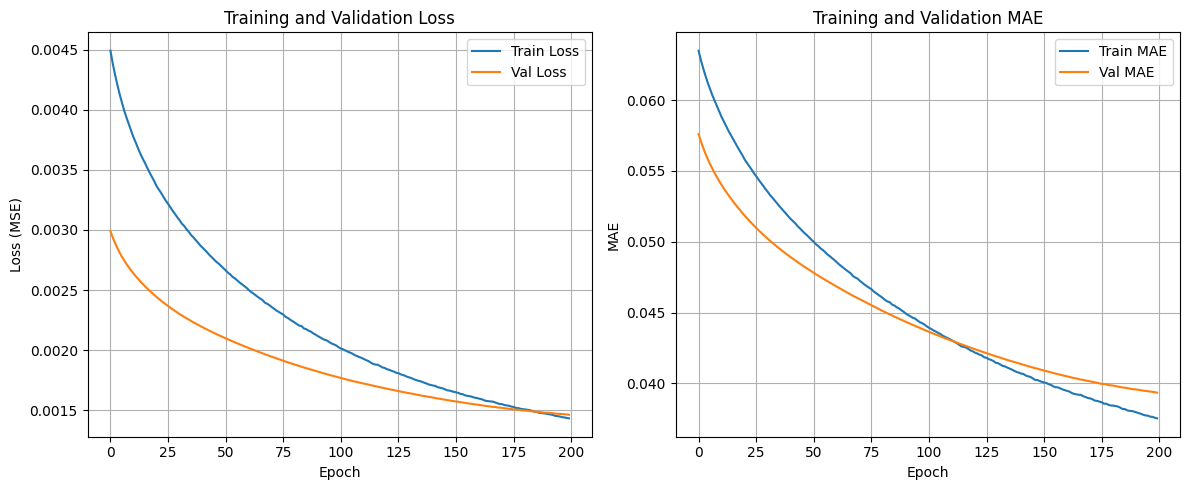

In [ ]:
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def step_rse_corr(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)
    rse = np.sqrt(np.sum((yt - yp) ** 2) / (np.sum((yt - np.mean(yt)) ** 2) + 1e-8))
    corr, _ = pearsonr(yt, yp)
    return rse, corr

In [ ]:
def step_all_metrics(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)

    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)
    smape = 100 * np.mean(2 * np.abs(yt - yp) / (np.abs(yt) + np.abs(yp) + 1e-8))
    rse = np.sqrt(np.sum((yt - yp)**2) / (np.sum((yt - np.mean(yt))**2) + 1e-8))
    corr, _ = pearsonr(yt, yp)

    return {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape,
        'RSE': rse,
        'CORR': corr
    }

In [ ]:
y_test = np.concatenate(
    [y.numpy() for x, y in test_dataset.take(validation_steps)],
    axis=0
)

In [ ]:
y_pred = model.predict(test_dataset, steps=validation_steps)

87/87 ━━━━━━━━━━━━━━━━━━━━ 49s 551ms/step


In [ ]:
print(f'Model Name: Patched TalNet')
for step in [3, 6, 12, 24]:
    m = step_all_metrics(y_test, y_pred, step)
    print(f"Step {step:2d} --> R²={m['R2']:.4f}, RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}, "
          f"MSE={m['MSE']:.4f}, SMAPE={m['SMAPE']:.2f}%, RSE={m['RSE']:.4f}, CORR={m['CORR']:.4f}")


Model Name: Patched TalNet
Step  3 --> R²=0.9858, RMSE=0.0410, MAE=0.0300, MSE=0.0017, SMAPE=6.22%, RSE=0.1190, CORR=0.9930
Step  6 --> R²=0.9845, RMSE=0.0429, MAE=0.0313, MSE=0.0018, SMAPE=6.49%, RSE=0.1245, CORR=0.9923
Step 12 --> R²=0.9825, RMSE=0.0457, MAE=0.0334, MSE=0.0021, SMAPE=6.80%, RSE=0.1324, CORR=0.9913
Step 24 --> R²=0.9779, RMSE=0.0514, MAE=0.0373, MSE=0.0026, SMAPE=7.53%, RSE=0.1487, CORR=0.9891


## Plots after train

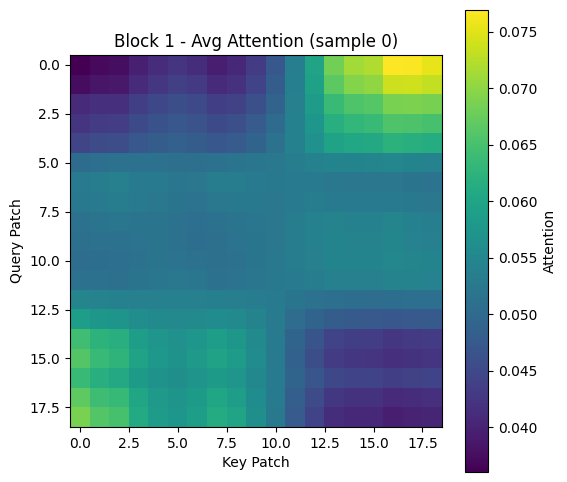

In [ ]:
# Attention block HEATMAP

x_sample, y_sample = next(iter(test_dataset.take(1)))
_ = model(x_sample, training=False)
attn_scores_all = model.last_attention_scores

sample_idx = 0  # first sample in the batch
block_idx = 0  # first transformer block

# pick attention of this block
attn_block = attn_scores_all[block_idx][sample_idx]

# average over heads
attn_avg = tf.reduce_mean(attn_block, axis=0)

plt.figure(figsize=(6,6))
plt.imshow(attn_avg, cmap='viridis')
plt.colorbar(label='Attention')
plt.xlabel('Key Patch')
plt.ylabel('Query Patch')
plt.title(f'Block {block_idx+1} - Avg Attention (sample {sample_idx})')
plt.show()

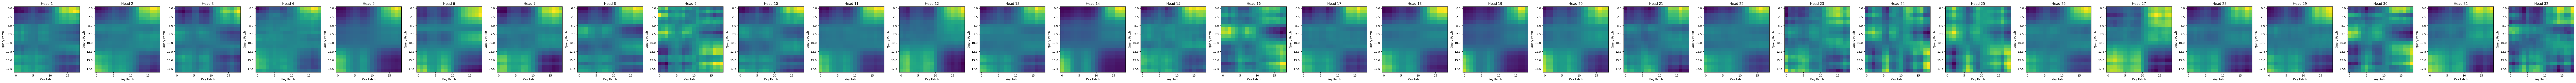

In [ ]:
n_heads = attn_block.shape[0]

fig, axes = plt.subplots(1, n_heads, figsize=(4*n_heads, 4))
for h in range(n_heads):
    axes[h].imshow(attn_block[h], cmap='viridis')
    axes[h].set_title(f'Head {h+1}')
    axes[h].set_xlabel('Key Patch')
    axes[h].set_ylabel('Query Patch')
plt.tight_layout()
plt.show()

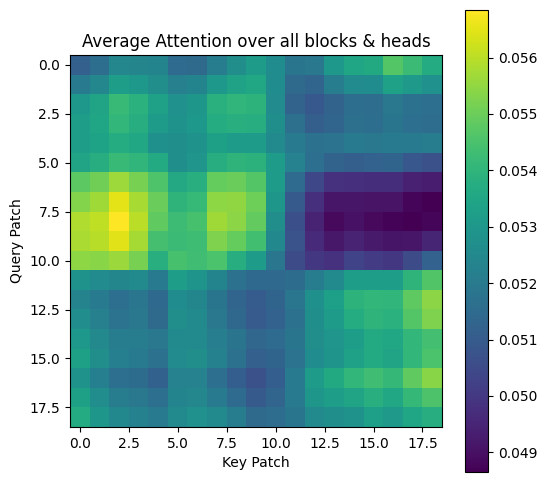

In [ ]:
# Average attention plot over all blocks

attn_stack = np.stack(attn_scores_all, axis=0)
attn_sample = attn_stack[:, sample_idx]
attn_avg_all = attn_sample.mean(axis=(0,1))

plt.figure(figsize=(6,6))
plt.imshow(attn_avg_all, cmap='viridis')
plt.colorbar()
plt.title('Average Attention over all blocks & heads')
plt.xlabel('Key Patch')
plt.ylabel('Query Patch')
plt.show()

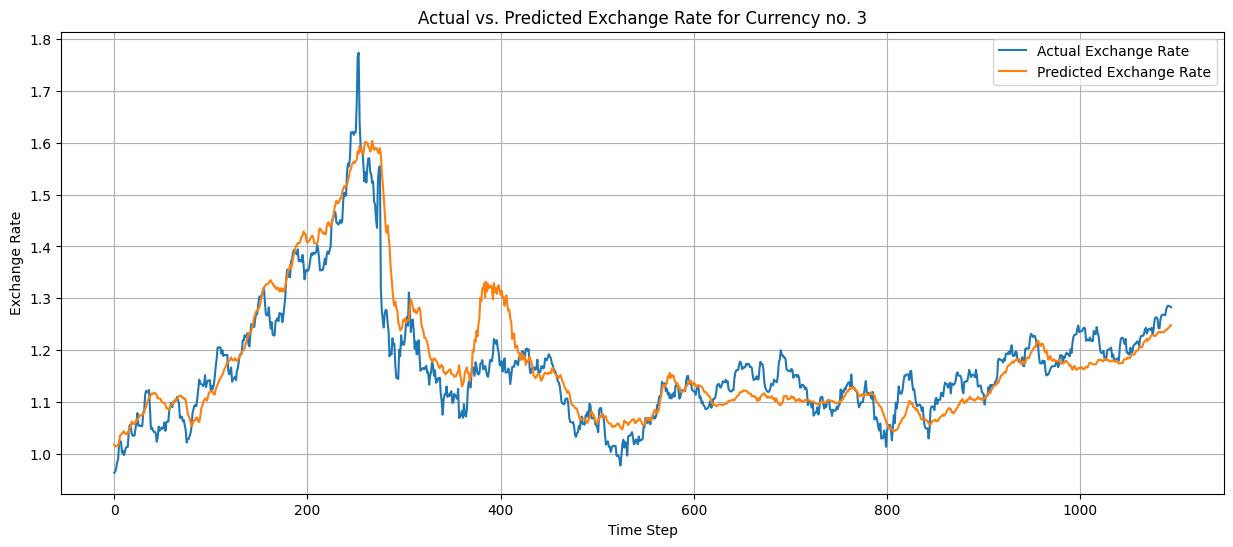

In [ ]:
sample_node = 3
sample_time_steps = 365*3

plt.figure(figsize=(15, 6))
plt.plot(y_test[:sample_time_steps, 0, sample_node], label='Actual Exchange Rate')
plt.plot(y_pred[:sample_time_steps, 0, sample_node], label='Predicted Exchange Rate')
plt.title(f'Actual vs. Predicted Exchange Rate for Currency no. {sample_node}')
plt.xlabel('Time Step')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

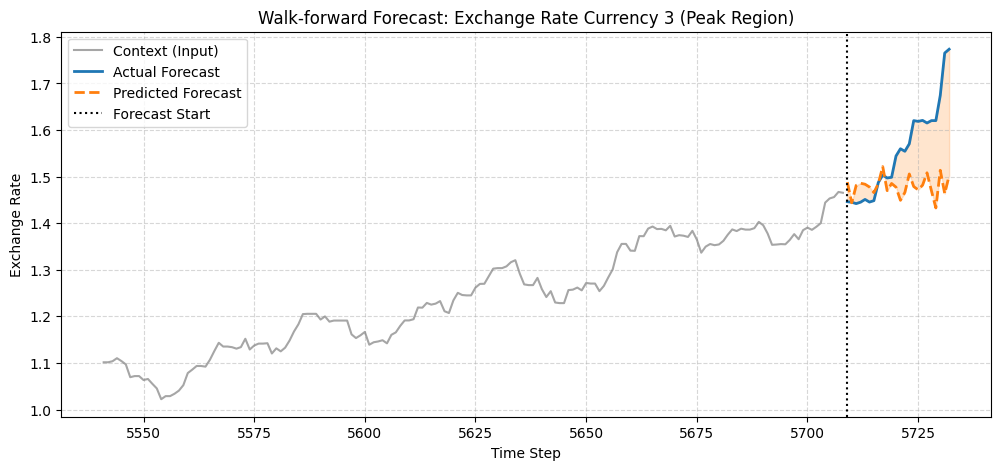

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


currency_idx = 3
peak_window_idx = np.argmax(np.max(y_test[:, :, currency_idx], axis=1))

# Define window boundaries based on the peak index
context_start = peak_window_idx
context_end = peak_window_idx + window_size
forecast_start = context_end
forecast_end = context_end + forecast_horizon

plt.figure(figsize=(12, 5))

# Plot the historical context (Input)
plt.plot(df_test.index[context_start:context_end],
         df_test.iloc[context_start:context_end, currency_idx],
         label='Context (Input)', color='gray', alpha=0.7)

# Extract time indices for the forecast period
forecast_index = df_test.index[forecast_start:forecast_end]
actual_vals = y_test[peak_window_idx, :, currency_idx].flatten()
pred_vals = y_pred[peak_window_idx, :, currency_idx].flatten()

# Plot Actual vs Predicted for the forecast horizon
plt.plot(forecast_index, actual_vals, label='Actual Forecast', color='tab:blue', linewidth=2)
plt.plot(forecast_index, pred_vals, label='Predicted Forecast', color='tab:orange', linestyle='--', linewidth=2)

# Vertical line to separate history from future
plt.axvline(x=df_test.index[forecast_start], color='black', linestyle=':', label='Forecast Start')

# Shaded area representing the error between prediction and reality
plt.fill_between(forecast_index, actual_vals, pred_vals, color='tab:orange', alpha=0.2)

plt.title(f'Walk-forward Forecast: Exchange Rate Currency {currency_idx} (Peak Region)')
plt.xlabel('Time Step')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

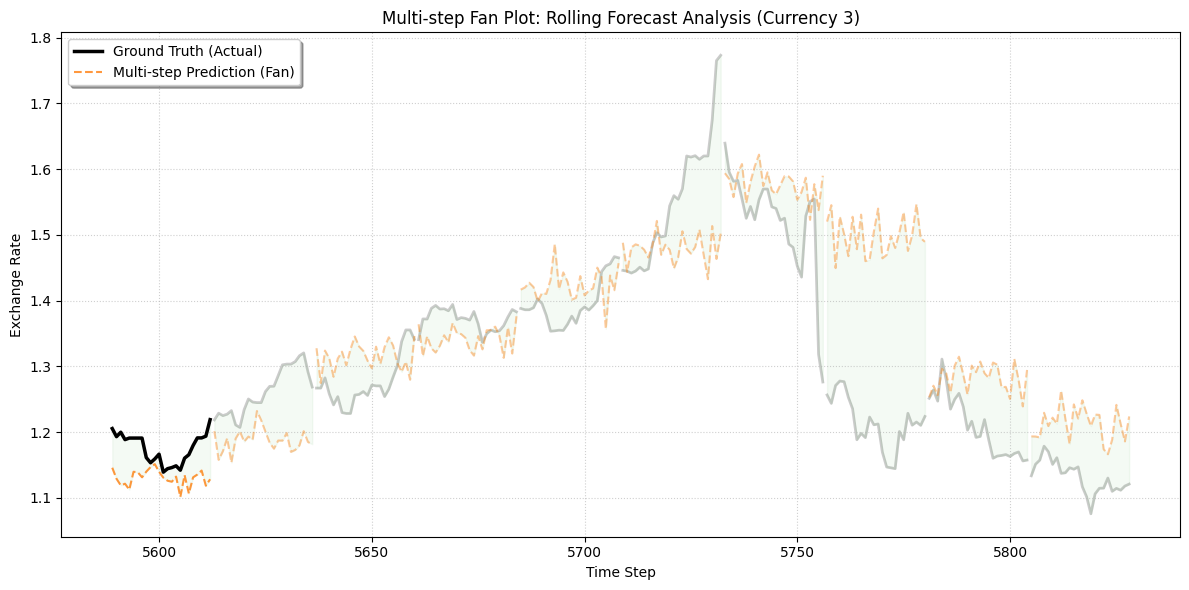

In [ ]:
# Multi-step “fan” plot (per currency, one start time)

import matplotlib.pyplot as plt
import numpy as np

currency_idx = 3
n_forecasts = 10
step_size = forecast_horizon

plt.figure(figsize=(12, 6))

start_offset = np.argmax(np.max(y_test[:, :, currency_idx], axis=1)) - (n_forecasts * step_size // 2)

for i in range(n_forecasts):
    win_idx = start_offset + (i * step_size)

    forecast_idx = df_test.index[win_idx + window_size : win_idx + window_size + forecast_horizon]
    actual_vals = y_test[win_idx, :, currency_idx].flatten()
    pred_vals = y_pred[win_idx, :, currency_idx].flatten()

    if i == 0:
        plt.plot(forecast_idx, actual_vals, color='black', linewidth=2.5, label='Ground Truth (Actual)', zorder=10)
        plt.plot(forecast_idx, pred_vals, color='tab:orange', alpha=0.8, linestyle='--', label='Multi-step Prediction (Fan)', zorder=5)
    else:
        plt.plot(forecast_idx, actual_vals, color='black', linewidth=2, alpha=0.2, zorder=1)
        plt.plot(forecast_idx, pred_vals, color='tab:orange', alpha=0.4, linestyle='--', zorder=5)

    plt.fill_between(forecast_idx, actual_vals, pred_vals, color='tab:green', alpha=0.05)

plt.title(f'Multi-step Fan Plot: Rolling Forecast Analysis (Currency {currency_idx})')
plt.xlabel('Time Step')
plt.ylabel('Exchange Rate')
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

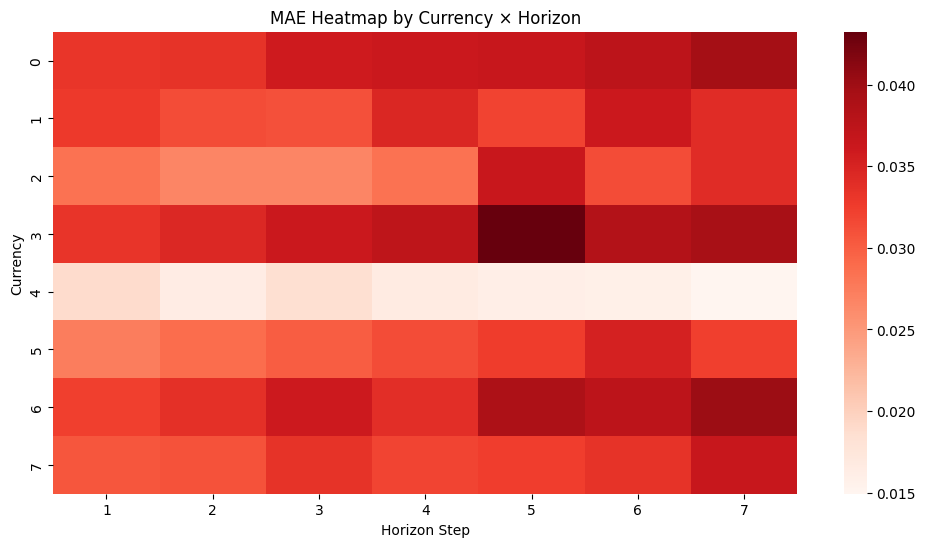

In [ ]:
# Heatmap: Error by Currency × Horizon
import seaborn as sns
error_matrix = np.zeros((y_test.shape[2], 7))

for c in range(y_test.shape[2]):
    for h in range(7):
        error_matrix[c, h] = mean_absolute_error(y_test[:, h, c], y_pred[:, h, c])

plt.figure(figsize=(12,6))
sns.heatmap(error_matrix, cmap='Reds', xticklabels=range(1,7+1))
plt.xlabel('Horizon Step')
plt.ylabel('Currency')
plt.title('MAE Heatmap by Currency × Horizon')
plt.show()

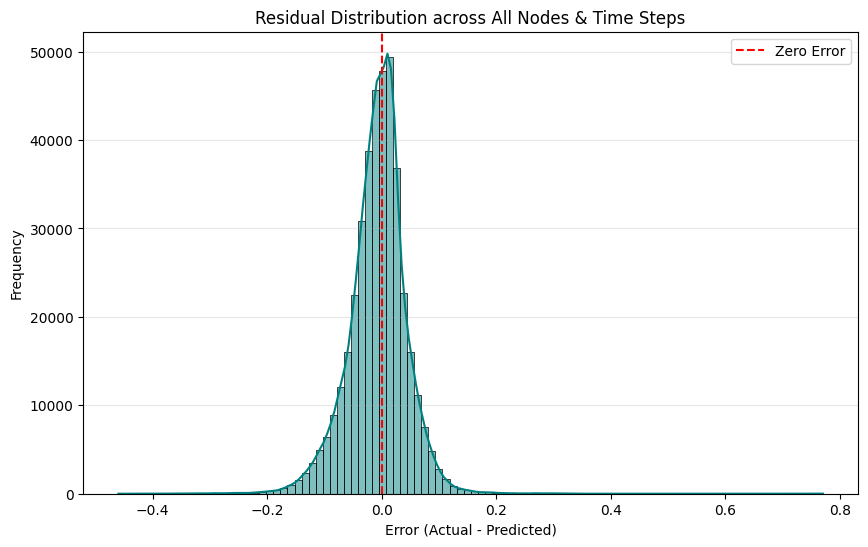

Mean Residual: -0.0071
Residual Std Dev: 0.0509


In [ ]:
# Residual Distribution

residuals = (y_test - y_pred).flatten()
plt.figure(figsize=(10, 6))

# Plotting the distribution with a Kernel Density Estimate (KDE)
sns.histplot(residuals, kde=True, color='teal', bins=100)

# Add a vertical line at 0 to show the perfect prediction center
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Zero Error')

plt.title('Residual Distribution across All Nodes & Time Steps')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print basic residual statistics
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Residual Std Dev: {np.std(residuals):.4f}")

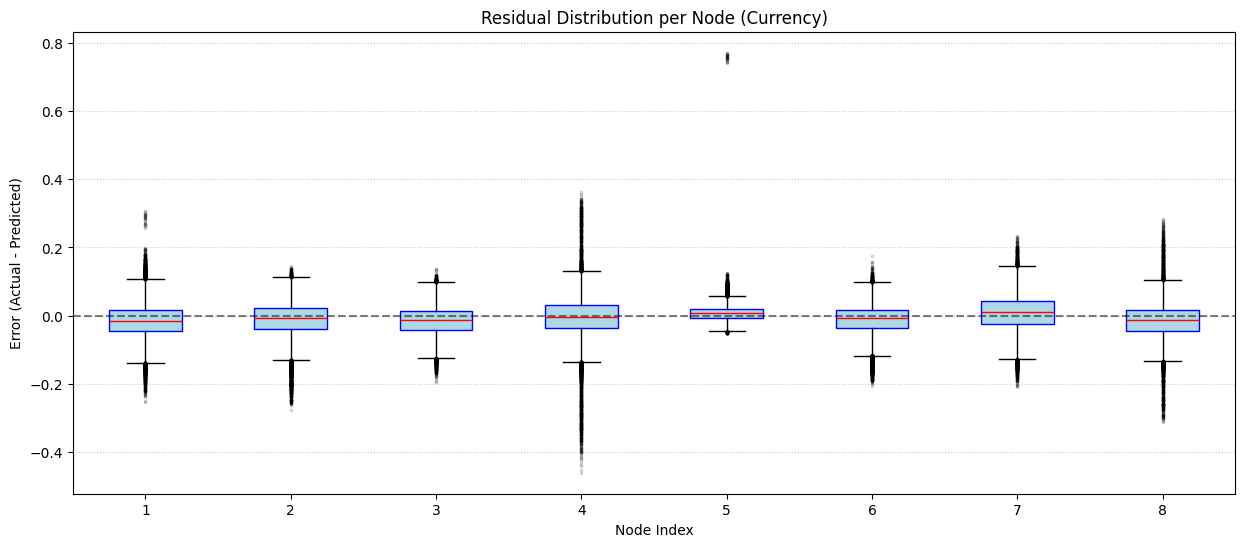

In [ ]:
# Calculate residuals per node (samples, horizon, nodes)

res_per_node = (y_test - y_pred).reshape(-1, y_test.shape[-1])

plt.figure(figsize=(15, 6))
plt.boxplot(res_per_node, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            flierprops=dict(marker='.', markersize=3, alpha=0.2))

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Residual Distribution per Node (Currency)')
plt.xlabel('Node Index')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()

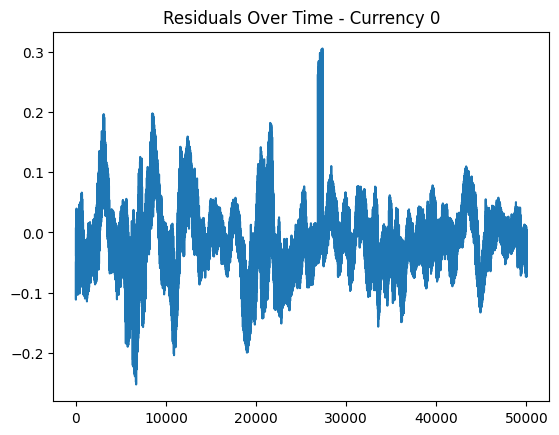

In [ ]:
plt.plot(residuals[:, :, 0].flatten())
plt.title('Residuals Over Time - Currency 0')
plt.show()

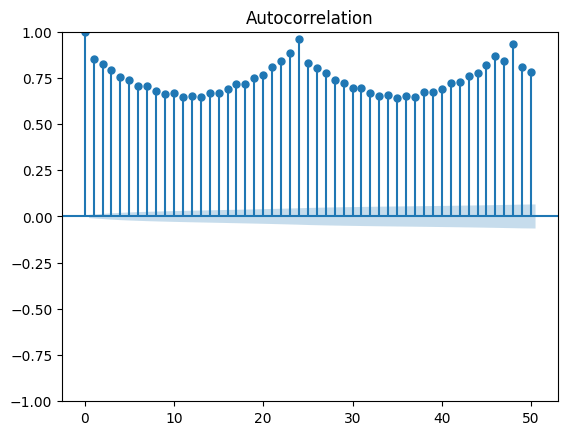

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals[:, :, 0].flatten(), lags=50)
plt.show()

# Model saving

In [ ]:
model.save('/content/drive/MyDrive/data/varsity/PatchedTalNet_exchange.keras')

In [ ]:
save_dir = "/content/drive/MyDrive/data/varsity/PatchedTalNet_exchange.keras"
model = tf.keras.models.load_model(save_dir, compile=False)
print("Model loaded successfully")

Model loaded successfully


# Model Loading with fix


In [ ]:
import zipfile

In [ ]:
keras_path = "/content/drive/MyDrive/data/varsity/TalNetV2_exchange.keras"
extract_dir = "/content/extracted_model"

with zipfile.ZipFile(keras_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")
print("Contents:", os.listdir(extract_dir))

Extraction complete.
Contents: ['metadata.json', 'config.json', 'model.weights.h5']


In [ ]:
model = PatchedTalNet(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    patch_len=32,
    patch_stride=24,
    d_model=64,
    n_heads=6,
    n_stack=3,
    dropout_rate=0.33
)

dummy = tf.random.normal((1, 168, 8))
_ = model(dummy)

print("Model built.")

Model built.


In [ ]:
weights_path = os.path.join(extract_dir, "model.weights.h5")

model.load_weights(weights_path)

print("Weights restored successfully.")

Weights restored successfully.


In [ ]:
save_dir = "/content/drive/MyDrive/data/varsity/PatchedTalNet_exchange.keras"
model.save(save_dir)  # saves in SavedModel format
print(f"Model saved successfully at {save_dir}")

Model saved successfully at /content/drive/MyDrive/data/varsity/PatchedTalNet_exchange.keras


In [ ]:
loaded_model = tf.keras.models.load_model(save_dir, compile=False)
print("Model loaded successfully")

Model loaded successfully
